In [75]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib import patches as patches
import pandas as pd
import seaborn as sns
import os
import plotly.express as px
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split

import torch
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# Load Dataset

In [76]:
df_annotation = pd.read_csv("/kaggle/input/blood-cell-detection-dataset/annotations.csv")
df_annotation.head()

,image,xmin,ymin,xmax,ymax,label
0,image-100.png,0.000000,0.000000,25.190198,40.816803,rbc
1,image-100.png,15.010502,0.000000,68.337223,23.527421,rbc
2,image-100.png,25.017503,16.021004,78.374562,73.735123,rbc
3,image-100.png,75.565928,1.061844,140.248541,45.591599,rbc
4,image-100.png,77.483081,23.290548,131.936989,74.806301,rbc


In [77]:
root_dir = "/kaggle/input/blood-cell-detection-dataset/images"

df_annotation["pathname"] = df_annotation["image"].map(lambda x : root_dir + f"/{x}")
df_annotation.head()

,image,xmin,ymin,xmax,ymax,label,pathname
0,image-100.png,0.000000,0.000000,25.190198,40.816803,rbc,/kaggle/input/blood-cell-detection-dataset/ima...
1,image-100.png,15.010502,0.000000,68.337223,23.527421,rbc,/kaggle/input/blood-cell-detection-dataset/ima...
2,image-100.png,25.017503,16.021004,78.374562,73.735123,rbc,/kaggle/input/blood-cell-detection-dataset/ima...
3,image-100.png,75.565928,1.061844,140.248541,45.591599,rbc,/kaggle/input/blood-cell-detection-dataset/ima...
4,image-100.png,77.483081,23.290548,131.936989,74.806301,rbc,/kaggle/input/blood-cell-detection-dataset/ima...


In [78]:
df_annotation["width"] = df_annotation["xmax"] - df_annotation["xmin"]
df_annotation["height"] = df_annotation["ymax"] - df_annotation["ymin"]
df_annotation.head()

,image,xmin,ymin,xmax,ymax,label,pathname,width,height
0,image-100.png,0.000000,0.000000,25.190198,40.816803,rbc,/kaggle/input/blood-cell-detection-dataset/ima...,25.190198,40.816803
1,image-100.png,15.010502,0.000000,68.337223,23.527421,rbc,/kaggle/input/blood-cell-detection-dataset/ima...,53.326721,23.527421
2,image-100.png,25.017503,16.021004,78.374562,73.735123,rbc,/kaggle/input/blood-cell-detection-dataset/ima...,53.357060,57.714119
3,image-100.png,75.565928,1.061844,140.248541,45.591599,rbc,/kaggle/input/blood-cell-detection-dataset/ima...,64.682614,44.529755
4,image-100.png,77.483081,23.290548,131.936989,74.806301,rbc,/kaggle/input/blood-cell-detection-dataset/ima...,54.453909,51.515753


# Exploratory Data Analysis

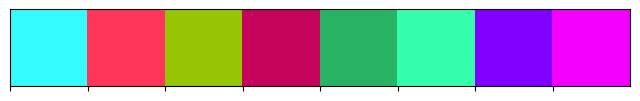

In [79]:
#Create custom color for bounding box
custom_colors = ['#35FCFF', '#FF355A', '#96C503', '#C5035B', '#28B463', '#35FFAF', '#8000FF', '#F400FF']
hex2rgb = lambda hx: (int(hx[1:3],16),int(hx[3:5],16),int(hx[5:7],16))
rgbcolors = list(map(hex2rgb, custom_colors))[1:]
sns.palplot(sns.color_palette(custom_colors))

In [80]:
img_path = df_annotation["pathname"][0]

label2hex = {k:v for k, v in 
               zip(df_annotation['label'].value_counts().index.tolist(), custom_colors[1:])}
label2rgb = {k:v for k, v in 
               zip(df_annotation['label'].value_counts().index.tolist(), rgbcolors)}

In [81]:
#Create function for visualization image
def plot_img_sample(df, img_path, colors = label2hex):
    #load image using cv
    image = cv2.imread(img_path).astype("uint8")
    #convert image to rgb from bgr
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    #create figure and ax for plotting image
    fig, ax = plt.subplots(nrows = 1, ncols = 2, sharey = True, figsize = (30,10))
    #plot image in second column
    ax[1].imshow(image, aspect = "auto")
    #set titile for original image
    ax[1].set_title("Original Image", fontsize = 30, fontweight = "bold")
    #set title for image with bounding boxes
    ax[0].set_title("Image with bounding boxes", fontsize = 30, fontweight = "bold")
    
    #create variable with array contains coordinate bounding boxes and labels
    bb_info = df.loc[df["pathname"] == img_path, ["xmin", "xmax","ymin","ymax","label"]].values
    #looping for visualization bounding boxes
    for i_bb in bb_info:
        #coordinat bounding boxes and label
        cmin, cmax, rmin, rmax = i_bb[:-1].astype("int")
        label = i_bb[-1]
        #create rectacgle for bounding box
        bbox = patches.Rectangle((cmin,rmin), cmax-cmin, rmax-rmin, linewidth = 2, 
                                 edgecolor = label2hex[label], facecolor = "none")
        ax[0].add_patch(bbox)
        #add text for each bounding boxe with label
        ax[0].text(cmin,rmin,label, bbox = dict(fill = True, color = label2hex[label]))
        ax[0].imshow(image, aspect = "auto")
    plt.tight_layout()
    plt.show()

In [82]:
#Create seed
seed = 1
def universal_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
seed_state = universal_seed(seed)

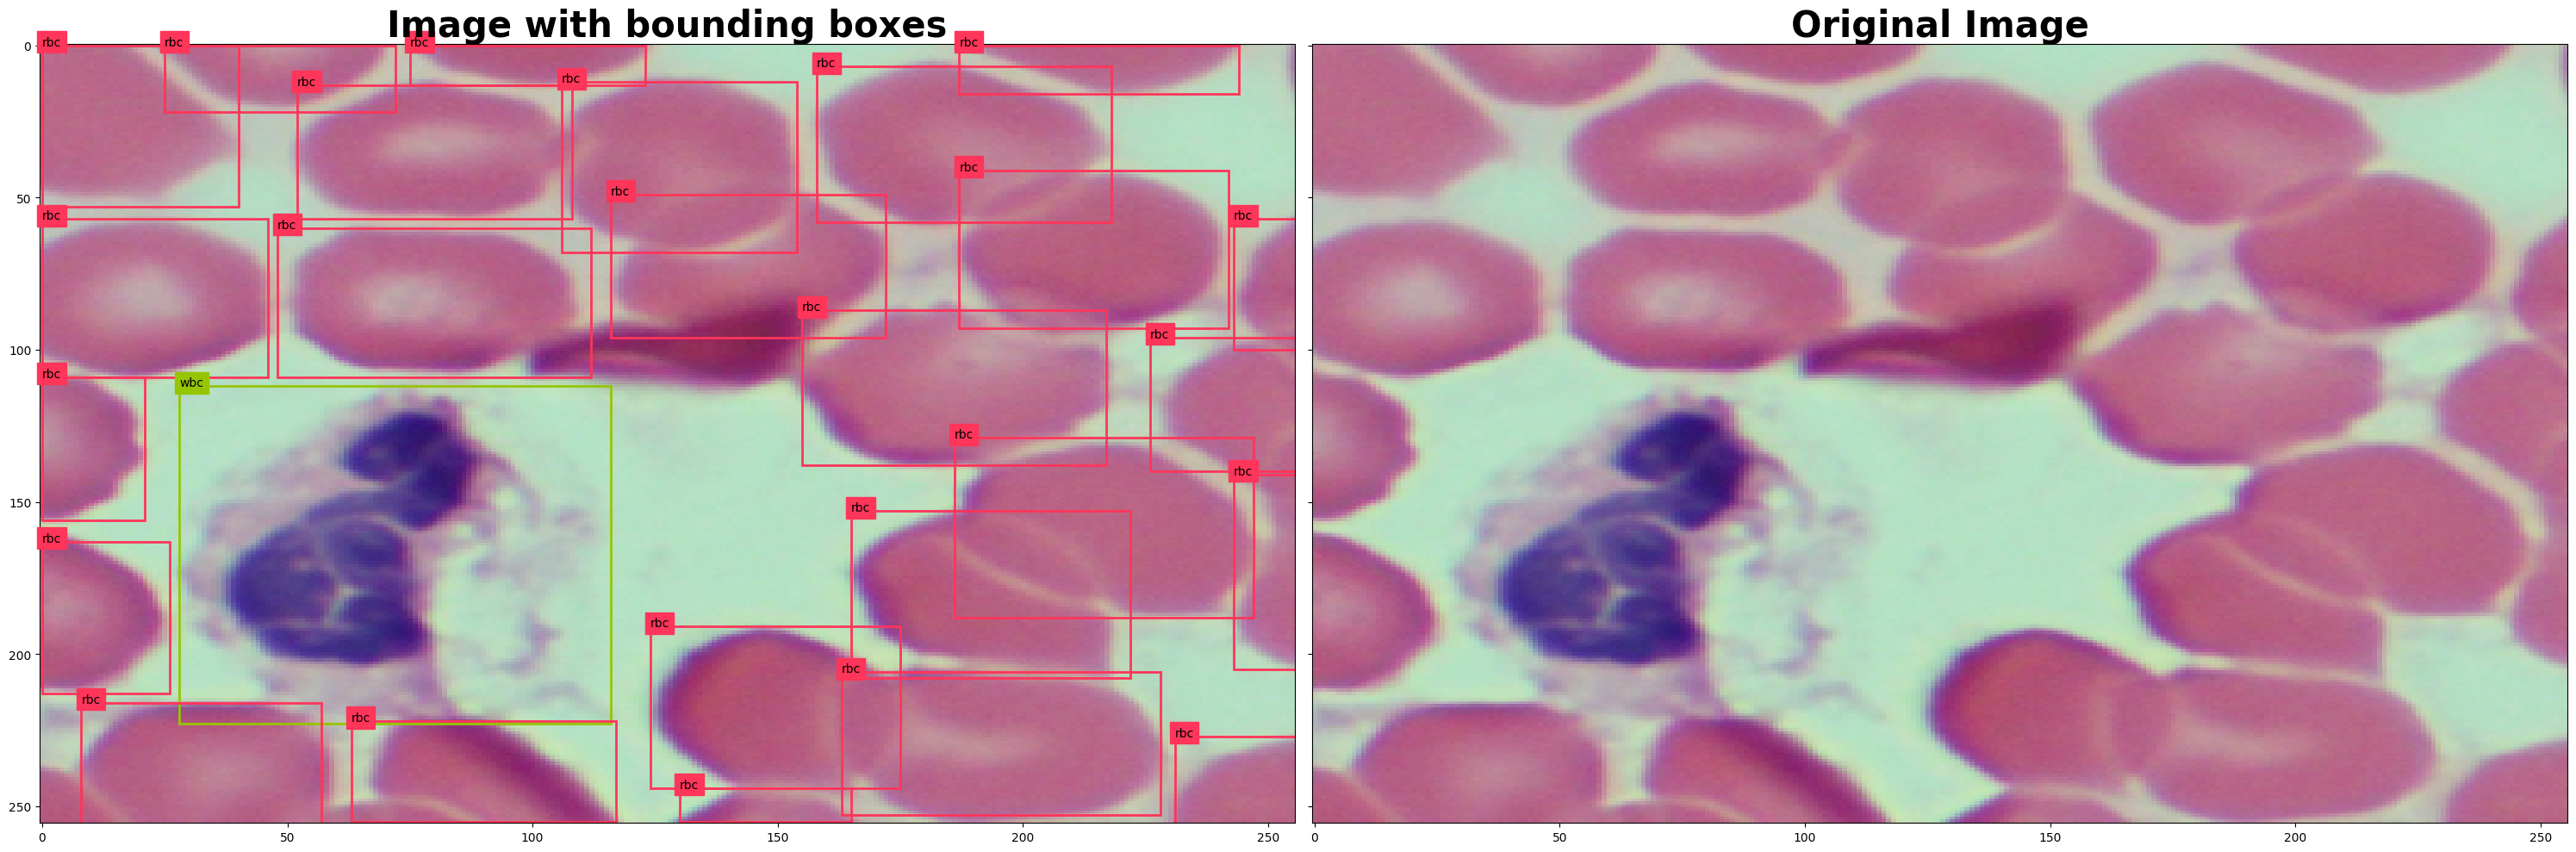

In [83]:
img_path = df_annotation["pathname"].sample(seed_state).values[0]
plot_img_sample(df_annotation, img_path, colors = label2hex)

In [84]:
#Plot distribution of classes
count_label = df_annotation["label"].value_counts().reset_index()
fig = px.histogram(data_frame = count_label, x = "label", y = "count")
fig.update_layout(title = "Distribution of Classes")
fig.update_traces(marker = dict(color = ["red","blue"]),
                 text = count_label["count"].tolist(),
                 textposition = "outside")
fig.show()

In [85]:
df = df_annotation.pivot_table(index = ["pathname"], aggfunc = "size").reset_index()
df = df.rename({0 : "count"}, axis = 1)
fig = go.Figure(go.Bar(x = df.index, y = df["count"].values))
fig.update_layout(title = "Distribution of Bounding Boxes in Image")
fig.update_traces(marker = dict(color = "blue"))
fig.show()

In [86]:
df["shape"] = df["pathname"].map(lambda x : cv2.imread(x).shape).astype(str)
shape = df["shape"].value_counts().reset_index()
shape

,shape,count
0,"(256, 256, 3)",100


# Faster RCNN

## Create Dataset

In [87]:
remap_labels = {"rbc" : 1, "wbc" : 2}
df_annotation["label_enc"] = df_annotation["label"].apply(lambda x : remap_labels[x])
df_annotation.head()

,image,xmin,ymin,xmax,ymax,label,pathname,width,height,label_enc
0,image-100.png,0.000000,0.000000,25.190198,40.816803,rbc,/kaggle/input/blood-cell-detection-dataset/ima...,25.190198,40.816803,1
1,image-100.png,15.010502,0.000000,68.337223,23.527421,rbc,/kaggle/input/blood-cell-detection-dataset/ima...,53.326721,23.527421,1
2,image-100.png,25.017503,16.021004,78.374562,73.735123,rbc,/kaggle/input/blood-cell-detection-dataset/ima...,53.357060,57.714119,1
3,image-100.png,75.565928,1.061844,140.248541,45.591599,rbc,/kaggle/input/blood-cell-detection-dataset/ima...,64.682614,44.529755,1
4,image-100.png,77.483081,23.290548,131.936989,74.806301,rbc,/kaggle/input/blood-cell-detection-dataset/ima...,54.453909,51.515753,1


In [88]:
class BloodCellData(Dataset):
    def __init__(self, df, transforms = None):
        super().__init__()
        self.image_ids = df["pathname"].unique()
        self.df = df
        self.transforms = transforms
        
    def __getitem__(self, index):
        image_id = self.image_ids[index]
        records = self.df[self.df["pathname"] == image_id]
        
        image = cv2.imread(image_id)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = image/255.0
        
        boxes = records[["xmin","ymin","xmax","ymax"]].values
        
        area = records["width"].values * records["height"].values
        area = torch.as_tensor(area, dtype = torch.float32)
        
        labels = records["label_enc"].values
        labels = torch.as_tensor(labels, dtype=torch.int64)
        
        iscrowd = torch.zeros(records.shape[0], dtype = torch.int64)
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = torch.tensor([index])
        target["iscrwod"] = iscrowd
        
        if self.transforms:
            sample = {"image":image,
                      "bboxes":target["boxes"],
                      "labels":labels}
            sample = self.transforms(**sample)
            image = sample["image"]
            target["boxes"] = torch.tensor(sample["bboxes"])
        return image, target, image_id
    def __len__(self):
        return self.image_ids.shape[0]

In [89]:
train_trans = A.Compose([A.Flip(p=0.4),
                        A.HorizontalFlip(p=0.3),
                        #A.RandomCrop(width=224,height=224,p=0.2),
                        ToTensorV2(p=0.1)], A.BboxParams(format="pascal_voc", min_visibility = 0.2, label_fields=["labels"]))

test_trans = A.Compose([ToTensorV2(p=0.1)],
                      A.BboxParams(format="pascal_voc", label_fields=["labels"]))

# Train Test Split

In [90]:
image_ids = df_annotation["pathname"].unique()
image_train, image_temp = train_test_split(image_ids, test_size = 0.3, shuffle = True)
image_valid, image_test = train_test_split(image_temp, test_size = 0.5, shuffle = True)

train_df = df_annotation[df_annotation["pathname"].isin(image_train)].reset_index(drop=True)
test_df = df_annotation[df_annotation["pathname"].isin(image_test)].reset_index(drop=True)
valid_df = df_annotation[df_annotation["pathname"].isin(image_valid)].reset_index(drop=True)

In [91]:
train_data = BloodCellData(train_df, train_trans)
valid_data = BloodCellData(valid_df, test_trans)
test_data = BloodCellData(test_df, test_trans)

In [92]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_data_loader = DataLoader(
    train_data,
    batch_size = 4,
    shuffle = False,
    num_workers = 0,
    collate_fn = collate_fn
)

valid_data_loader = DataLoader(
    valid_data,
    batch_size = 4,
    shuffle = False,
    num_workers = 0,
    collate_fn = collate_fn
)

test_data_loader = DataLoader(
    test_data,
    batch_size = 4,
    shuffle = False,
    num_workers = 0,
    collate_fn = collate_fn
)

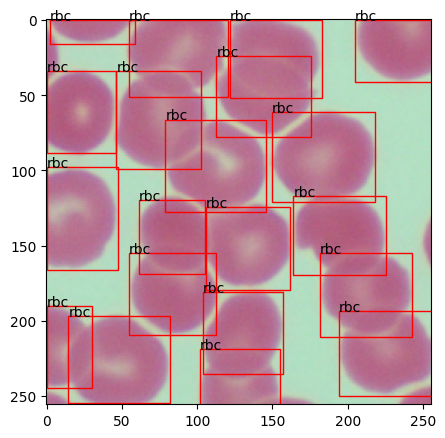

In [93]:
image,target,image_id = next(iter(train_data_loader))

img = image[1]
box = target[1]
box = box["boxes"]
label2category = {1 : "rbc", 2 : "wbc"}
labels = target[1]["labels"].numpy()

fig, ax = plt.subplots(figsize=(7,5))
ax.imshow(img.permute(1,2,0))
for label, (x_min, y_min, x_max, y_max) in zip(labels,box):
    rect = patches.Rectangle((x_min, y_min), x_max-x_min, y_max-y_min,edgecolor = "red", facecolor = "none")
    ax.add_patch(rect)
    ax.text(x_min, y_min, label2category[label])

# Check GPU

In [94]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Fine Tuning Model

In [95]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained = False, weights_backbone = False)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning:

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights_backbone' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights_backbone=None`.



In [96]:
num_classes = 3

in_features = model.roi_heads.box_predictor.cls_score.in_features

model.roi_heads.box_predictor = FastRCNNPredictor(in_features,num_classes)

In [97]:
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr = 0.004, momentum = 0.9, weight_decay = 0.0005)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = "min",
                                                         patience=3, verbose=2)

In [98]:
num_epochs = 20
model.train()
for epoch in range(num_epochs):
    cost = 0
    for images, targets, image_ids in train_data_loader:
        image = list(image.to(device).float() for image in images)
        target = [{k: v.to(device) for k, v, in t.items()} for t in targets]
        #Feed Forward
        loss_dict = model(image,target)
        losses = sum(loss for loss in loss_dict.values())
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        cost += losses.item()
    lr_scheduler.step(cost)
    cost /= len(train_data_loader)
    print(f"\rEpoch : {epoch+1} | train_loss : {cost:.3}")        

Epoch : 1 | train_loss : 1.84
Epoch : 2 | train_loss : 1.51
Epoch : 3 | train_loss : 1.29
Epoch : 4 | train_loss : 1.24
Epoch : 5 | train_loss : 1.21
Epoch : 6 | train_loss : 1.23
Epoch : 7 | train_loss : 1.22
Epoch : 8 | train_loss : 1.17
Epoch : 9 | train_loss : 1.14
Epoch : 10 | train_loss : 1.08
Epoch : 11 | train_loss : 1.06
Epoch : 12 | train_loss : 1.01
Epoch : 13 | train_loss : 0.969
Epoch : 14 | train_loss : 0.945
Epoch : 15 | train_loss : 0.924
Epoch : 16 | train_loss : 0.888
Epoch : 17 | train_loss : 0.879
Epoch : 18 | train_loss : 0.832
Epoch : 19 | train_loss : 0.79
Epoch : 20 | train_loss : 0.792


In [99]:
def format_prediction(boxes, scores, labels):
    results = np.zeros((len(boxes),6))
    for i,(j) in enumerate(zip(scores,boxes,labels)):
        results[i,0] = j[0]
        results[i,1] = j[1][0]
        results[i,2] = j[1][1]
        results[i,3] = j[1][2]
        results[i,4] = j[1][3]
        results[i,5] = j[2]
    return results

In [102]:
model.eval()
ids = []
results = []
images, targets, image_ids = next(iter(valid_data_loader))
img_lst = list(im.to(device).float() for im in images)
output = model(img_lst)

In [103]:
for i, image in enumerate(images):
    boxes = output[i]["boxes"].data.cpu().numpy()
    scores = output[i]["scores"].data.cpu().numpy()
    labels = output[i]["labels"].data.cpu().numpy()
    image_id = image_ids[i]
    boxes = boxes[scores >= 0.60].astype(np.int32)
    scores = scores[scores >= 0.60]
    
    result = format_prediction(boxes, scores, labels)
    
    sum_id = result.shape[0]*[image_id]
    results.append(result)
    ids.append(sum_id)

In [104]:
val_df = pd.DataFrame(np.concatenate(results), columns = ["scores", "xmin", "ymin", "xmax", "ymax", "label"])
val_df["pathname"] = sum(ids,[])
label2cat = {1 : "rbc", 2 : "wbc"}
val_df["category"] = val_df["label"].map(lambda x : label2cat[x])
val_df["label"] = val_df["label"].astype(int)
val_df["pathname"].value_counts()

pathname
/kaggle/input/blood-cell-detection-dataset/images/image-100.png    25
/kaggle/input/blood-cell-detection-dataset/images/image-107.png    24
/kaggle/input/blood-cell-detection-dataset/images/image-102.png    23
/kaggle/input/blood-cell-detection-dataset/images/image-1.png      21
Name: count, dtype: int64

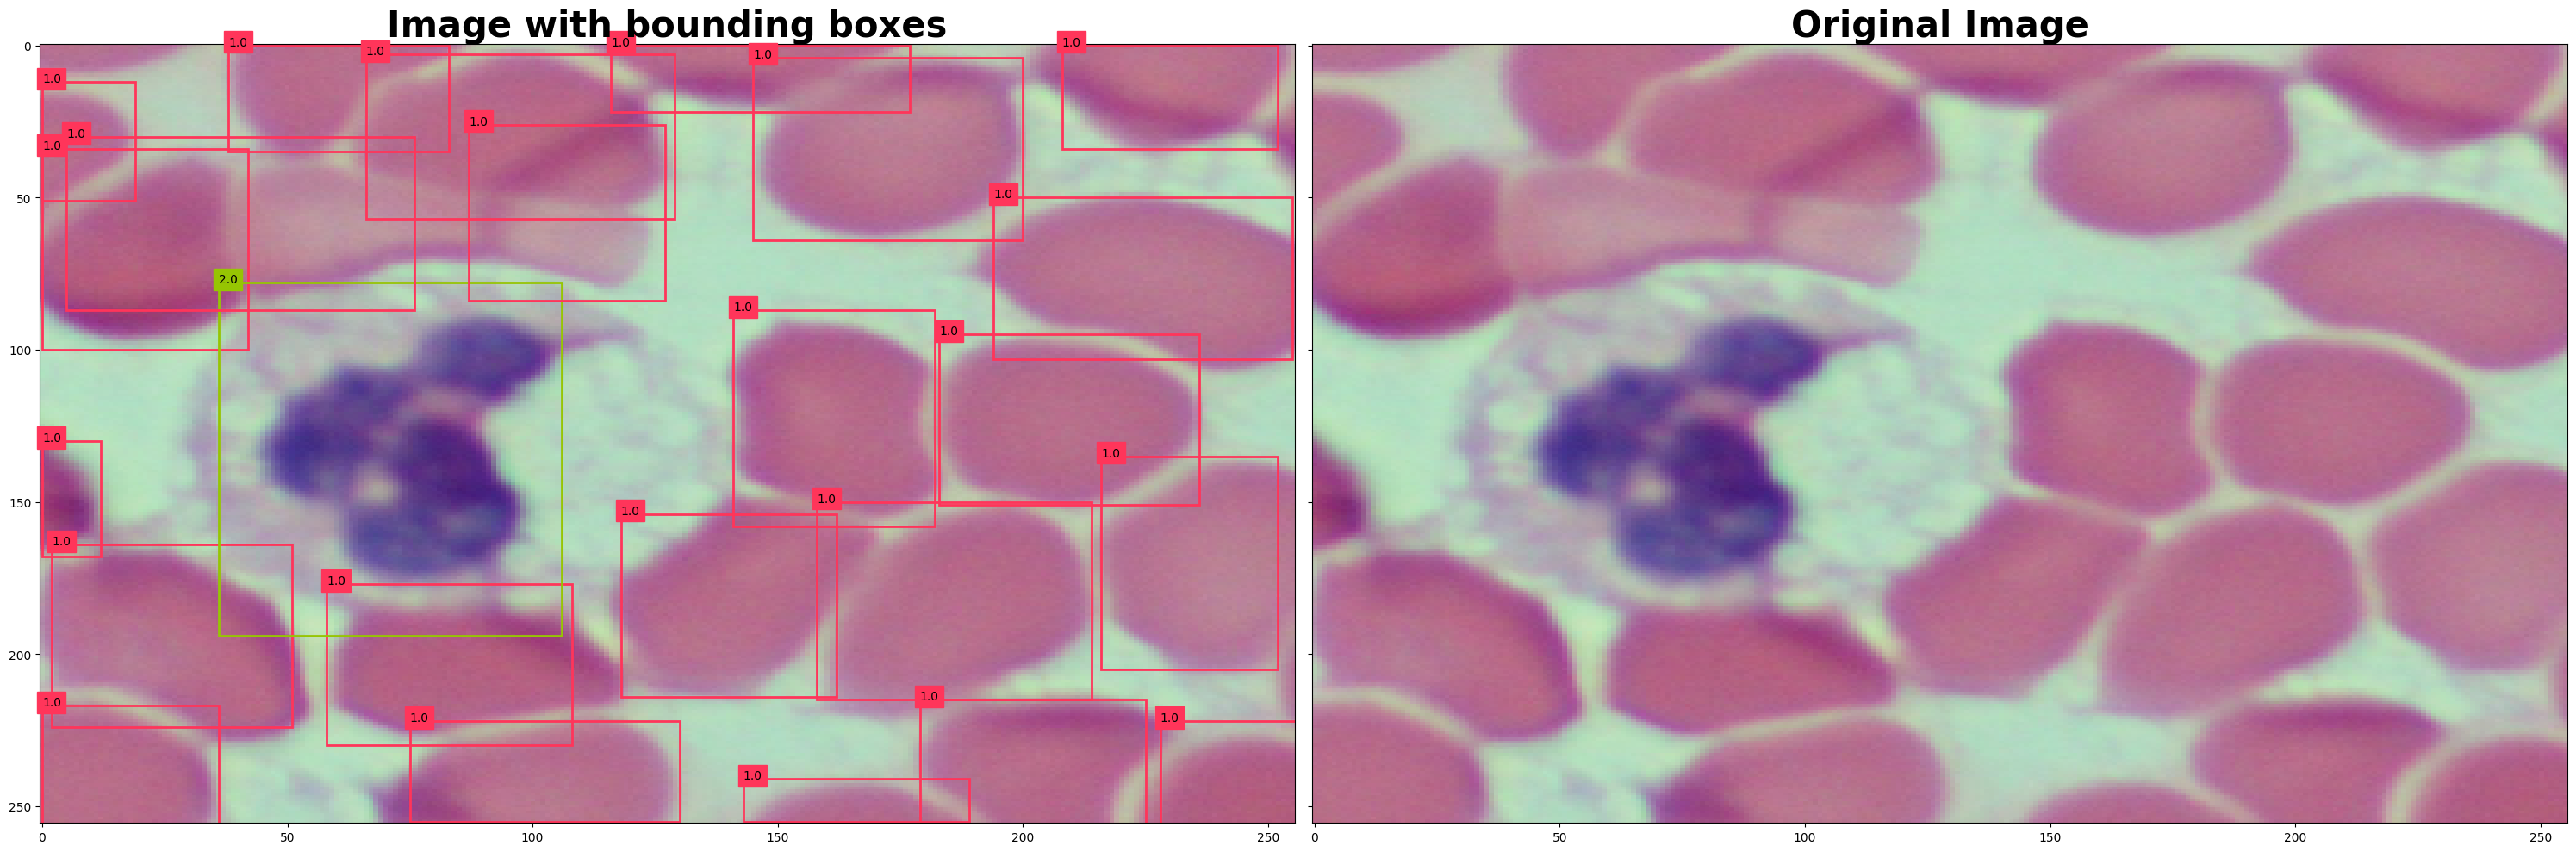

In [127]:
val_path = val_df["pathname"].unique()[3]

label2hex = {k:v for k, v in 
               zip(val_df['label'].value_counts().index.tolist(), custom_colors[1:])}
plot_img_sample(val_df,val_path)